In [34]:
import cv2
import scipy.io as scio
import glob
import os 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
color=[[0,0,0],[128,0,0],[0,128,0],[128,128,0],[0,0,128],[0,128,128],
       [128,128,128],[192,0,0],[64,128,0],[192,128,0],[64,0,128],[192,0,128],
       [64,128,128],[192,128,128],[0,64,0],[128,64,0],
       [0,192,0],[128,64,128],[0,192,128],[128,192,128],
       [64,64,0],[192,64,0]]

In [35]:
data_root = './msrc2_seg'
files = glob.glob1(os.path.join(data_root,'images'),'*.bmp')
f100 = files[100]
img = cv2.imread(os.path.join(data_root,'images',f100))[:,:,[2,1,0]]
gt = cv2.imread(os.path.join(data_root,'gt',f100[:-4]+'_GT.bmp'))[:,:,[2,1,0]]
h,w = img.shape[:-1]
mask = np.zeros((h,w),dtype=np.uint8)
for i,tmp in enumerate(color):
    mask_rgb = (gt==tmp)
    if i == 0:
        mask = mask+(mask_rgb[:,:,0]*mask_rgb[:,:,1]*mask_rgb[:,:,2])*255
    else :
        mask = mask+(mask_rgb[:,:,0]*mask_rgb[:,:,1]*mask_rgb[:,:,2])*(i)


(-0.5, 319.5, 212.5, -0.5)

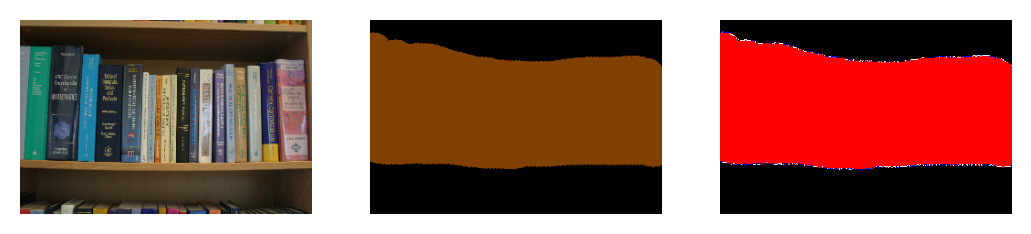

In [36]:
f,(ax1,ax2,ax3) = plt.subplots(1,3,dpi=200)
ax1.imshow(img)
ax1.axis('off')
ax2.imshow(gt)
ax2.axis('off')
ax3.imshow(mask,cmap='flag')
ax3.axis('off')


In [64]:
class map():
    def __init__(self,color) -> None:
        self.color = color
    def img2label(self,img):
        img = np.array(img)
        h,w = img.shape[:2]
        mask = np.zeros((h,w),dtype=np.uint8)
        for i,tmp in enumerate(color):
            mask_rgb = (img==tmp)
            mask = mask+(mask_rgb[:,:,0]*mask_rgb[:,:,1]*mask_rgb[:,:,2])*(i)
        return mask
    def label2img(self,label):
        w,h = label.shape[:2]
        im0 = np.zeros((w,h,3),dtype=np.int32)
        for i in range(w):
            for j in range(h):
                c = label[i,j]
                im0[i,j,0]=self.color[c][0]
                im0[i,j,1]=self.color[c][1]
                im0[i,j,2]=self.color[c][2]
        return im0

In [38]:
import random
import torch
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader
import pandas as pd

In [39]:
class RandomCrop(object):
    """
    图像与label随机裁剪相同的位置
    """
    def __init__(self, size):
        self.size = size

    @staticmethod
    def get_params(img, output_size):
        w, h = img.size
        th, tw = output_size
        if w == tw and h == th:
            return 0, 0, h, w
        i = random.randint(0, h - th)
        j = random.randint(0, w - tw)
        return i, j, th, tw

    def __call__(self, img, label):
        i, j, h, w = self.get_params(img, self.size)
        return img.crop((j, i, j + w, i + h)), label.crop((j, i, j + w, i + h))


In [40]:
class generateDataset():
    """
    划分数据集，默认划分为:276,59,256
    并将划分后的文件路径存入csv
    """
    def __init__(self,data_root):
        self.data_root=data_root
        self.generate()
    def generate(self,seed:int = 42,train_s=276,val_s=59,test_s=256):
        files = glob.glob1(os.path.join(self.data_root,'images'),'*.bmp')
        path1 = []
        path2 = []
        for f in files:
            img_path = os.path.join(data_root,'images',f)
            gt_path = os.path.join(data_root,'gt',f[:-4]+'_GT.bmp')
            path1.append(os.path.normpath(img_path))
            path2.append(os.path.normpath(gt_path))
        random.seed(seed)
        rlist = list(range(len(path1)))
        random.shuffle(rlist)
        clist = list(zip(rlist,path1,path2))
        clist.sort()
        _,path1,path2=zip(*clist)
        trainset = list(path1[:train_s]),list(path2[:train_s])
        valset = list(path1[train_s:train_s+val_s]),list(path2[train_s:train_s+val_s])
        testset = list(path1[train_s+val_s:]),list(path2[train_s+val_s:])
        traindf = pd.DataFrame(trainset).T
        valdf = pd.DataFrame(valset).T
        testdf = pd.DataFrame(testset).T
        traindf.to_csv(os.path.join(self.data_root,'train.csv'),index=False)
        valdf.to_csv(os.path.join(self.data_root,'val.csv'),index=False)
        testdf.to_csv(os.path.join(self.data_root,'test.csv'),index=False)
generateDataset(data_root)
os.path.exists(os.path.join(data_root,'train.csv'))


True

In [41]:
class myDataset(Dataset):
    def __init__(self, data_root, input_width, input_height):
        super(myDataset, self).__init__()
        self.data_root = data_root
        self.data_all = pd.read_csv(self.data_root)
        
        self.image_list = list(self.data_all.iloc[:, 0])
        self.label_list = list(self.data_all.iloc[:, 1])
        self.width = input_width
        self.height = input_height

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        img = Image.open(self.image_list[index]).convert('RGB')
        label = Image.open(self.label_list[index]).convert('RGB')

        img, label = self.train_transform(
            img, label, crop_size=(self.width, self.height))

        return img, label

    def train_transform(self, image, label, crop_size=(256, 256)):

        image, label = RandomCrop(crop_size)(
            image, label) 
        tfs = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([.485, .456, .406], [.229, .224, .225])
        ])
        image = tfs(image)
        label = map(color).img2label(label)
        label = torch.from_numpy(label).long()
        return image, label


In [42]:
import torch.nn as nn
import torch.nn.functional as F

In [43]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)
    

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(
                scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


In [44]:
class mIoU():
    def __init__(self,gt,pre,n_class):
        self.gt = gt
        self.pre = pre
        self.n_class = n_class

    def _fast_hist(label_true, label_pred, n_class):
        mask = (label_true >= 0) & (label_true < n_class)
        hist = np.bincount(
            n_class * label_true[mask].astype(int) +
            label_pred[mask], minlength=n_class ** 2).reshape(n_class, n_class)
        return hist

    def score(self):
        hist = np.zeros((self.n_class, self.n_class))
        for lt, lp in zip(self.gt, self.pre):
            hist += self._fast_hist(lt.flatten(), lp.flatten(), self.n_class)
        iou = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
        miou = np.nanmean(iou)
        return miou


In [45]:
import torch.optim as optim

In [67]:
GPU_ID = 0
INPUT_WIDTH = 200
INPUT_HEIGHT = 200
BATCH_SIZE = 2
NUM_CLASSES = 22
LEARNING_RATE = 1e-3
epoch = 300
net = UNet(3, NUM_CLASSES)

generateDataset(data_root)

model_path = './model_result/best_model_UNet.mdl'

train_csv_dir = os.path.join(data_root,'train.csv')
val_csv_dir = os.path.join(data_root,'val.csv')

train_data = myDataset(train_csv_dir, INPUT_WIDTH, INPUT_HEIGHT)
train_dataloader = DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

val_data = myDataset(val_csv_dir, INPUT_WIDTH, INPUT_HEIGHT)
val_dataloader = DataLoader(
    val_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

net = UNet(3, NUM_CLASSES)
use_gpu = torch.cuda.is_available()

# 构建网络
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
if use_gpu:
    torch.cuda.set_device(GPU_ID)
    net.cuda()
    criterion = criterion.cuda()

if os.path.exists(model_path):
    net.load_state_dict(torch.load(model_path))
    print('Successfully loaded model weights')
else:
    print('There is no existing weights')

# 训练验证
best_score = 0.0
for e in range(epoch):
    net.train()
    train_loss = 0.0
    label_true = torch.LongTensor()
    label_pred = torch.LongTensor()
    for i, (batchdata, batchlabel) in enumerate(train_dataloader):
        if use_gpu:
            batchdata, batchlabel = batchdata.cuda(), batchlabel.cuda()

        output = net(batchdata)
        output = F.log_softmax(output, dim=1)
        loss = criterion(output, batchlabel)

        pred = output.argmax(dim=1).squeeze().data.cpu()
        real = batchlabel.data.cpu()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.cpu().item() * batchlabel.size(0)
        label_true = torch.cat((label_true, real), dim=0)
        label_pred = torch.cat((label_pred, pred), dim=0)

    train_loss /= len(train_data)

    train_score = mIoU(label_true.numpy(), label_pred.numpy(), NUM_CLASSES)
    miou = train_score.score()

    print('\nepoch:{}, train_loss:{:.4f},miou:{:.4f}'.format(
        e + 1, train_loss, miou))

    net.eval()
    val_loss = 0.0
    val_label_true = torch.LongTensor()
    val_label_pred = torch.LongTensor()
    with torch.no_grad():
        for i, (batchdata, batchlabel) in enumerate(val_dataloader):
            if use_gpu:
                batchdata, batchlabel = batchdata.cuda(), batchlabel.cuda()

            output = net(batchdata)
            output = F.log_softmax(output, dim=1)
            loss = criterion(output, batchlabel)

            pred = output.argmax(dim=1).data.cpu()
            real = batchlabel.data.cpu()

            val_loss += loss.cpu().item() * batchlabel.size(0)
            val_label_true = torch.cat((val_label_true, real), dim=0)
            val_label_pred = torch.cat((val_label_pred, pred), dim=0)

        val_loss /= len(val_data)
        val_score = mIoU(val_label_true.numpy(),
                              val_label_pred.numpy(), NUM_CLASSES)
        val_miou = val_score.score()
    print('epoch:{}, val_loss:{:.4f}, miou:{:.4f}'.format(
        e + 1, val_loss, val_miou))

    # 通过验证集的val_miou来判断模型效果，保存最好的模型权重
    score = val_miou
    if score > best_score:
        best_score = score
        torch.save(net.state_dict(), model_path)


There is no existing weights


KeyboardInterrupt: 

In [ ]:
GPU_ID = 0
INPUT_WIDTH = 200
INPUT_HEIGHT = 200
BATCH_SIZE = 2
NUM_CLASSES = 22
LEARNING_RATE = 1e-3
model_path = './model_result/best_model_UNet.mdl'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = UNet(3, NUM_CLASSES)
# 加载网络进行测试
test_csv_dir = os.path.join(data_root,'test.csv')
testset = myDataset(test_csv_dir, INPUT_WIDTH, INPUT_HEIGHT)
test_dataloader = DataLoader(testset, batch_size=15, shuffle=False)
net.load_state_dict(torch.load(model_path, map_location='cpu'))
test_label_true = torch.LongTensor()
test_label_pred = torch.LongTensor()

for (val_image, val_label) in test_dataloader:
    net.to(device)
    out = net(val_image.to(device))
    pred = out.argmax(dim=1).squeeze().data.cpu().numpy()
    label = val_label.data.numpy()
    output = F.log_softmax(out, dim=1)

    pred = output.argmax(dim=1).data.cpu()
    real = val_label.data.cpu()

    test_label_true = torch.cat((test_label_true, real), dim=0)
    test_label_pred = torch.cat((test_label_pred, pred), dim=0)

    test_score = mIoU(test_label_true.numpy(),
                           test_label_pred.numpy(), NUM_CLASSES)
    test_miou = test_score.score()

    print("测试集上的miou为:" + str(test_miou))
    myMap = map(color)
    val_pred, val_label = myMap.label2img(pred),myMap.label2img(label)
    for i in range(15):
        val_imag = val_image[i]
        val_pre = val_pred[i]
        val_labe = val_label[i]
        # 反归一化
        mean = [.485, .456, .406]
        std = [.229, .224, .225]
        x = val_imag
        for j in range(3):
            x[j] = x[j].mul(std[j])+mean[j]
        img = x.mul(255).byte()
        img = img.numpy().transpose((1, 2, 0))  # 原图
        fig, ax = plt.subplots(1, 3, figsize=(30, 30))
        ax[0].imshow(img)
        ax[1].imshow(val_labe)
        ax[2].imshow(val_pre)
        plt.show()
        plt.savefig('./pic_results/pic_UNet_{}.png'.format(i))
    break
